In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import seaborn as sns
from matplotlib.colors import LogNorm

import mne

import pandas as pd

import utils.mne_microstates as microstates
from utils import plotter
from utils.utils import *

from scipy.stats import ttest_rel

### Store info for plotting
#info = load_info()

n_subj = 44
subjects = np.arange(n_subj) + 1

tasks = ['REST', 'S 21', 'S 51', 'S 71', 'S 22', 'S 52', 'S 72']

sigma = 5
min_peak_dist = 5
n_states = 9

maps = np.load(f'results/best_maps.npy')

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
subj = 1
data = load_dataset(subj, sfreq=125, lfreq=None, hfreq=None)

Reading /home/barzon/Microstates/data_500_1_100/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.384 (s)


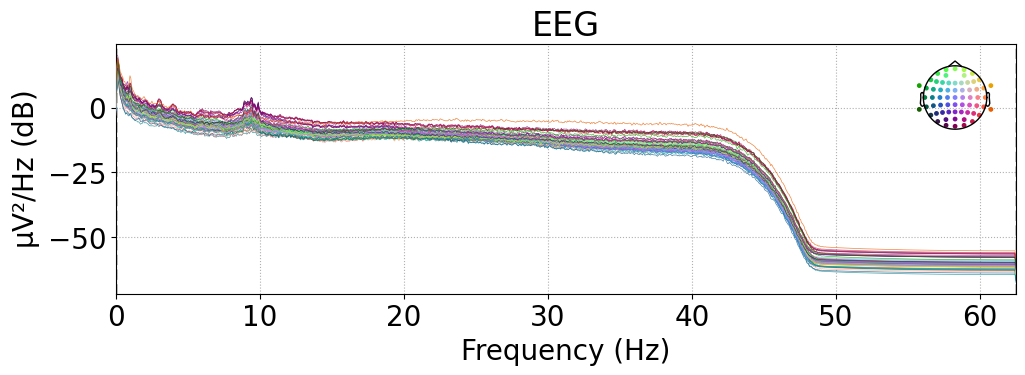

In [17]:
data.plot_psd()

In [3]:
data_array = data.get_data()

In [7]:
data_array.shape

(64, 610000)

In [8]:
np.savetxt(f'eeg_subj_{subj}.txt', data_array[:,:events[0,0]])

In [4]:
events, events_name = events_from_annotations(data)

Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']


In [6]:
events[0,0]

33767

In [32]:
tmp_events_name = np.array( [[key, value] for key, value in events_name.items()] )

In [36]:
tmp_events_name

array([['RT', '1'],
       ['S 21', '2'],
       ['S 22', '3'],
       ['S 51', '4'],
       ['S 52', '5'],
       ['S 71', '6'],
       ['S 72', '7'],
       ['S121', '8'],
       ['S122', '9'],
       ['S151', '10'],
       ['S152', '11'],
       ['S171', '12'],
       ['S172', '13']], dtype='<U21')

In [37]:
np.savetxt(f'events_name_subj_{subj}.txt', tmp_events_name, fmt='%s')

In [23]:
events_name

{'RT': 1,
 'S 21': 2,
 'S 22': 3,
 'S 51': 4,
 'S 52': 5,
 'S 71': 6,
 'S 72': 7,
 'S121': 8,
 'S122': 9,
 'S151': 10,
 'S152': 11,
 'S171': 12,
 'S172': 13}

In [2]:
df_prob = pd.read_csv('prob_states.csv')

In [17]:
# Joint transitions
tmat = np.fromfile('tmat.txt').reshape(n_subj, len(tasks), len(maps), len(maps))

# Joint transition probabilities
tmat = tmat / tmat.sum(axis=3).sum(axis=2)[...,None,None]

In [9]:
# Joint transitions
tmat = np.fromfile('tmat_all.txt').reshape(n_subj, len(tasks), len(maps), len(maps))

# Joint transition probabilities
tmat = tmat / tmat.sum(axis=3).sum(axis=2)[...,None,None]

In [18]:
# Entropy production
eprod = np.zeros((n_subj, len(tasks)))

for i_subj in range(n_subj):
    for i_task in range(len(tasks)):
        tmp = tmat[i_subj,i_task] * np.log(tmat[i_subj,i_task] / tmat[i_subj,i_task].T)
        tmp[np.isnan(tmp)] = 0
        tmp[np.isinf(tmp)] = 0
        
        eprod[i_subj,i_task] = tmp.sum()

/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/home/barzon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [19]:
### Create dataset
tmp_int = ['R', 'H', 'M', 'L', 'H', 'M', 'L']
tmp_cong = ['R', 'C', 'C', 'C', 'I', 'I', 'I']

col_subj = np.arange(1,n_subj+1).repeat(len(tasks))
col_cong = np.tile(tmp_cong, n_subj)
col_int = np.tile(tmp_int, n_subj)

dataset = pd.DataFrame({'Subject': col_subj, 'Cond': col_cong, 'Ctrl': col_int, 'EProd': eprod.flatten()})

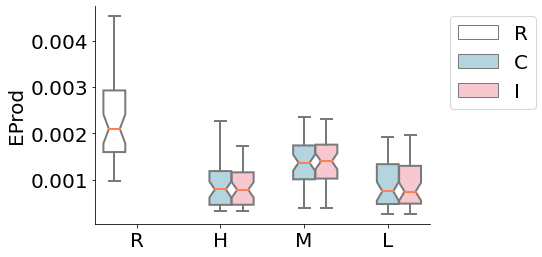

In [12]:
import seaborn as sns
from statannot import add_stat_annotation

x = "Ctrl"
y = "EProd"
hue = "Cond"
ax = sns.boxplot(data=dataset, x=x, y=y, hue=hue, palette={"C": "lightblue", "I": "pink", "R":"white"}, showfliers = False,
                 notch=True, width=0.8, medianprops={"color": "coral"})
ax.set_xlabel('')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
sns.despine(offset=0, trim=False)

'''
test_results = add_stat_annotation(ax, data=dataset, x=x, y=y, hue=hue,
                                   box_pairs=[( ("H","C"), ("L", "C") ), ( ("L","C"), ("L", "I") )],
                                   test='t-test_paired', text_format='star',
                                   loc='outside', verbose=2)
'''

plt.show()

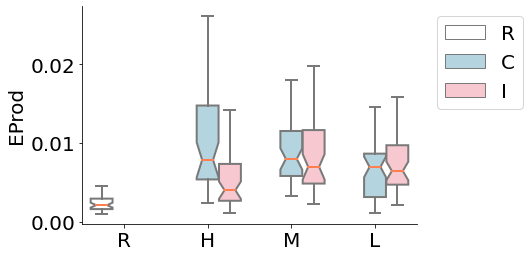

In [20]:
import seaborn as sns
from statannot import add_stat_annotation

x = "Ctrl"
y = "EProd"
hue = "Cond"
ax = sns.boxplot(data=dataset, x=x, y=y, hue=hue, palette={"C": "lightblue", "I": "pink", "R":"white"}, showfliers = False,
                 notch=True, width=0.8, medianprops={"color": "coral"})
ax.set_xlabel('')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
sns.despine(offset=0, trim=False)

'''
test_results = add_stat_annotation(ax, data=dataset, x=x, y=y, hue=hue,
                                   box_pairs=[( ("H","C"), ("L", "C") ), ( ("L","C"), ("L", "I") )],
                                   test='t-test_paired', text_format='star',
                                   loc='outside', verbose=2)
'''

plt.show()